In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
import json
import joblib
from sklearn.inspection import permutation_importance

In [2]:
RANDOM_STATE = 19
np.random.seed(RANDOM_STATE)

metrics_results = {}
search_summaries = {}
models = {}
predictions = {}

Используем функцию для подсчета метрик в задании на ансамбли, поскольку используется мультакласс, ROC-AUC вычисляется с параметром OVR

In [3]:
# Функция для вывода метрик в ансамблях
def print_metrics(y_true, y_pred, y_proba=None, title=None):
    if title:
        print(title)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            pass
    return {"accuracy": float(acc), "f1": float(f1), "roc_auc": float(auc) if y_proba is not None else None}

### Загрузка данных и первичный анализ

In [4]:
# Загрузка csv
df = pd.read_csv('S06-hw-dataset-03.csv')

In [5]:
# Минимальные сведения о датасете
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,target
0,1,-2.721419,0.652294,1.867234,-0.245331,-0.241182,-0.195509,1.180193,-0.724816,1.804165,...,0.042851,-0.153232,1.566167,-1.516125,-1.586857,-3.998937,-1.308459,2.155125,1.992519,0
1,2,-4.191520,-0.647731,-0.881929,-0.968159,3.530725,-4.858592,0.240979,-0.714017,0.285769,...,-1.170056,0.631661,1.277915,-0.464432,1.927986,6.034154,0.149833,4.861592,-3.547303,0
2,3,-0.582739,0.415128,-4.205613,-0.320853,0.313570,-2.655451,2.215387,1.492222,-0.516727,...,0.083281,-0.757912,5.672669,-0.283472,0.275362,-0.988055,0.940883,-3.050749,-0.703865,1
3,4,-1.766082,1.253523,1.610804,0.466067,3.837868,-3.564073,-1.831031,1.066265,-0.198636,...,-0.674648,1.780285,-4.718432,0.711573,1.705610,6.474380,-1.690537,8.687735,-2.799399,0
4,5,-2.157834,-1.361285,-0.917199,0.937285,0.408551,-0.062032,-0.480196,-0.554454,-1.026434,...,-0.096277,0.212875,1.710699,2.476220,0.669305,3.166072,-0.718493,3.630457,0.083986,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15000 non-null  int64  
 1   f01     15000 non-null  float64
 2   f02     15000 non-null  float64
 3   f03     15000 non-null  float64
 4   f04     15000 non-null  float64
 5   f05     15000 non-null  float64
 6   f06     15000 non-null  float64
 7   f07     15000 non-null  float64
 8   f08     15000 non-null  float64
 9   f09     15000 non-null  float64
 10  f10     15000 non-null  float64
 11  f11     15000 non-null  float64
 12  f12     15000 non-null  float64
 13  f13     15000 non-null  float64
 14  f14     15000 non-null  float64
 15  f15     15000 non-null  float64
 16  f16     15000 non-null  float64
 17  f17     15000 non-null  float64
 18  f18     15000 non-null  float64
 19  f19     15000 non-null  float64
 20  f20     15000 non-null  float64
 21  f21     15000 non-null  float64
 22

In [7]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,target
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,-0.840416,-0.011530,0.755463,0.008092,-0.246559,0.992538,-0.004599,-0.005366,0.011024,...,0.008801,0.004798,-0.060611,-0.008095,0.002397,0.699377,-0.001170,1.380216,0.150765,0.612600
std,4330.271354,1.785432,1.007374,3.663136,0.996556,2.216202,3.943110,2.113607,1.001960,1.006309,...,0.988931,0.999959,3.747823,0.994912,0.990567,3.801468,0.996588,3.929134,2.005847,0.740016
min,1.000000,-8.199174,-4.100091,-13.591257,-3.992807,-8.243563,-14.950758,-8.522298,-3.768197,-3.791645,...,-3.612116,-4.150852,-15.977469,-3.664246,-3.857890,-16.273835,-4.536600,-12.105957,-8.300728,0.000000
25%,3750.750000,-2.029608,-0.686265,-1.593729,-0.674039,-1.738188,-1.580544,-1.380091,-0.673001,-0.661451,...,-0.674236,-0.669654,-2.517892,-0.676471,-0.661098,-1.842677,-0.668133,-1.339314,-1.235425,0.000000
50%,7500.500000,-0.855943,-0.010454,0.744919,0.009431,-0.203512,1.110848,0.134466,-0.003663,0.004158,...,0.020916,0.010701,0.019034,-0.001622,0.001807,0.780608,-0.007763,1.108728,0.137089,0.000000
75%,11250.250000,0.313482,0.674347,3.057234,0.677459,1.254102,3.700201,1.443666,0.662753,0.683465,...,0.681036,0.676786,2.521745,0.659456,0.663270,3.297387,0.676626,3.869991,1.524830,1.000000
max,15000.000000,7.338969,4.418126,17.965154,3.887820,8.542916,15.618988,7.575797,3.698010,3.963730,...,3.497004,3.828639,12.661894,4.214633,4.378893,17.152063,3.618447,18.906060,8.007400,2.000000


In [8]:
# Распределение признака target
df['target'].value_counts(normalize=True)

target
0    0.542533
1    0.302333
2    0.155133
Name: proportion, dtype: float64

Из результата df.info() можем наблюдать, что пропусков в датасете нет, а типы данных всех столбцов признаков (т.е. кроме id и target) являются float64. id и target - int64.

In [9]:
# Определение признаков и таргета
y = df['target']
X = df.drop(columns=['id', 'target'])

### Train/Test-сплит и воспроизводимость

In [10]:
# Разделение данныч на train/test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

Стратификация нужна, чтобы распределение классов сохранялось в обучающей и тестовой выборках. Фиксированный seed, в свою очередь, обеспечивает воспроизводимость (полностью повторяемый результат при каждом запуске кода), таким образом становится возможно честное сравненить разные алгоритмы на одинаковых данных.

### Baseline’ы

In [26]:
# Бейзлайн-модель на основе DummyClassifier
dm = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dm.fit(X_train, y_train)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'stratified'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [88]:
# Оценка метрик для DummyClassifier
y_pred_dm = dm.predict(X_test)
y_pred_proba_dm = dm.predict_proba(X_test)

metrics_results['DummyClassier'] = print_metrics(y_test, y_pred_dm, y_pred_proba_dm, title='Dummy Classier Metrics')

Dummy Classier Metrics
accuracy = 0.4150
f1       = 0.3468
roc_auc  = 0.4987


In [16]:
# Построение Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

In [17]:
# Подбор параметра регуляризации C
lr_params = {
    'logreg__C': [0.01, 0.1, 1.0]
}

# GridSearchCV
lr_grid = GridSearchCV(
    estimator=pipe,
    param_grid=lr_params,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train)

print(f"Best params: {lr_grid.best_params_}")
print(f"Best CV score: {lr_grid.best_score_:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'logreg__C': 0.1}
Best CV score: 0.7203


In [18]:
# Обучение модели с выбранным параметром C и оценка
best_lr = lr_grid.best_estimator_
metrics_results['LogisticRegression'] = print_metrics(y_test, best_lr.predict(X_test), best_lr.predict_proba(X_test), title='Logistic Regression Metrics')

Logistic Regression Metrics
accuracy = 0.7220
f1       = 0.6600
roc_auc  = 0.8428


In [19]:
search_summaries['LogisticRegression'] = {
    'best_params': lr_grid.best_params_,
    'best_cv_score': float(lr_grid.best_score_)
}

В результате анализа метрик двух бейзлайн моделей, можно утверждать, что модель на основе логистической регрессии, постороенная через Pipeline, выдает значительно лучший результат в сравнении с DummyClassifier.

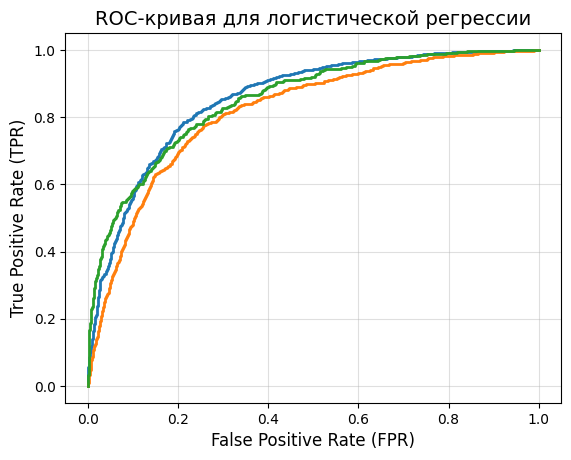

In [21]:
# Построение графика ROC-кривой (для мультикласса)
n_classes = 3
y_true_bin = label_binarize(y_test, classes=y.unique())
for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], best_lr.predict_proba(X_test)[:, i])
        auc_score = roc_auc_score(y_test, best_lr.predict_proba(X_test), multi_class='ovr')
        plt.plot(fpr, tpr, lw=2, 
                 label=f'{y.unique()[i]} (AUC={auc_score:.3f})')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривая для логистической регрессии', fontsize=14)
plt.grid(alpha=0.4)

# Сохранение графика
plt.savefig('artifacts/figures/roc.png')

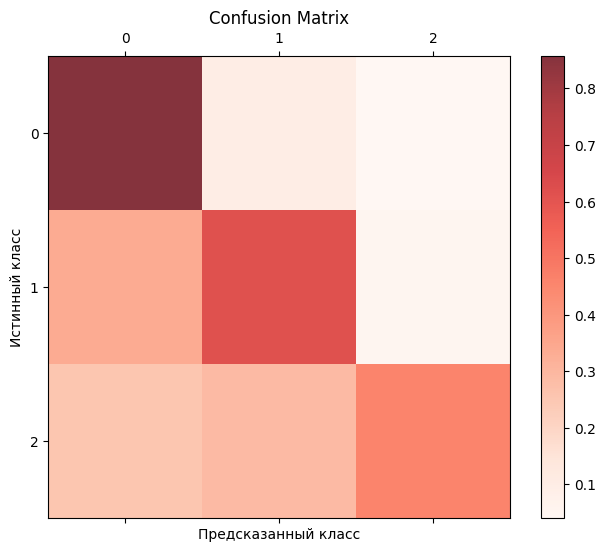

In [24]:
cm = confusion_matrix(y_test, best_lr.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.8)
plt.colorbar(cax)
plt.title('Confusion Matrix')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.savefig('artifacts/figures/confusion.png')

### Модели недели 6

#### Decision Tree Classifier

In [94]:
# Подбор гиперпараметров для Decision Tree Classifier через GridSearchCV
dt_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_leaf': [1, 2, 3, 5, 10, 20]
}

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

# GridSearchCV
dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=dt_params,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)

print(f"\nЛучшие параметры: {dt_grid.best_params_}")
print(f"Лучшая точность (CV): {dt_grid.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 5}
Лучшая точность (CV): 0.7371


In [95]:
# Обучение модели с лучшим выявленным набором гиперпараметров
best_dt = dt_grid.best_estimator_
metrics_results['DecisionTreeClassifier'] = print_metrics(y_test, best_dt.predict(X_test), best_dt.predict_proba(X_test), title='Decision Tree Metrics')

Decision Tree Metrics
accuracy = 0.7787
f1       = 0.7291
roc_auc  = 0.8418


In [96]:
search_summaries['DecisionTreeClassifier'] = {
    'best_params': dt_grid.best_params_,
    'best_cv_score': float(dt_grid.best_score_)
}

#### Random Forest Classifier

In [45]:
rf_params = {
    'max_depth': [3, 7, 15, None],
    'min_samples_leaf': [1, 3, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\nЛучшие параметры: {rf_grid.best_params_}")
print(f"Лучшая точность (CV): {rf_grid.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Лучшие параметры: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1}
Лучшая точность (CV): 0.8430


In [99]:
# Обучение модели с лучшим выявленным набором гиперпараметров
best_rf = rf_grid.best_estimator_
metrics_results['RandomForestClassifier'] = print_metrics(y_test, best_rf.predict(X_test), best_rf.predict_proba(X_test), title='Random Forest Metrics')

Random Forest Metrics
accuracy = 0.8840
f1       = 0.8585
roc_auc  = 0.9496


In [100]:
search_summaries['RandomForestClassifier'] = {
    'best_params': rf_grid.best_params_,
    'best_cv_score': float(rf_grid.best_score_)
}

#### AdaBoostClassifier

In [65]:
# Обучение AdaBoostClassifier с подбором гиперпараметров через GridSearchCV
ada_params = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.1, 0.6, 0.8]
}

stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)
ada = AdaBoostClassifier(random_state=RANDOM_STATE)

ada_grid = GridSearchCV(
    estimator=ada,
    param_grid=ada_params,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

ada_grid.fit(X_train, y_train)

print(f"\nЛучшие параметры: {ada_grid.best_params_}")
print(f"Лучшая точность (CV): {ada_grid.best_score_:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Лучшие параметры: {'learning_rate': 0.8, 'n_estimators': 200}
Лучшая точность (CV): 0.6368


In [102]:
# Обучение модели с лучшим выявленным набором гиперпараметров
best_ada = ada_grid.best_estimator_
metrics_results['AdaBoostClassifier'] = print_metrics(y_test, best_ada.predict(X_test), best_ada.predict_proba(X_test), title='Ada Boost Metrics')

Ada Boost Metrics
accuracy = 0.7023
f1       = 0.6275
roc_auc  = 0.8333


In [103]:
search_summaries['RandomForestClassifier'] = {
    'best_params': ada_grid.best_params_,
    'best_cv_score': float(ada_grid.best_score_)
}

#### StackingClassifier (2-3 базовых модели + метамодель)

In [25]:
estimators = [
    ("lr", Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=2000))])),
    ("rf", RandomForestClassifier(n_estimators=250, random_state=RANDOM_STATE, n_jobs=-1)),
    ("gb", GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=2, random_state=RANDOM_STATE)),
]

final_est = LogisticRegression(max_iter=2000)

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_train, y_train)
pred = stack.predict(X_test)
proba = stack.predict_proba(X_test)

metrics_results['StackingClassifier'] = print_metrics(y_test, pred, proba, title='Stacking Classifier Metrics')

Stacking Classifier Metrics
accuracy = 0.9033
f1       = 0.8821
roc_auc  = 0.9570


### Интерпретация

В результате сравнения моделей по критерию f1_macro видно, что лучшей является Stacking Classifier (f1 = 0.8821). Для неё подсчитаем permutation importance

In [26]:
perm = permutation_importance(
    stack, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="f1_macro"
)

importances = perm.importances_mean
# Сортируем признаки по важности (убывание) и возьмём top-12 для наглядного графика.
idx = np.argsort(importances)[::-1][:15]

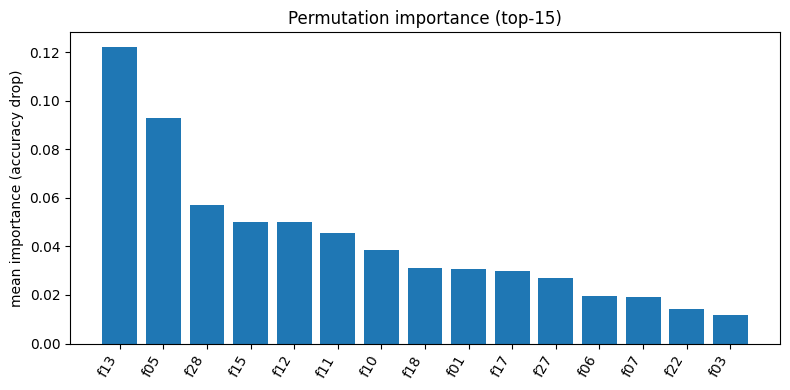

In [27]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [X.columns[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance (accuracy drop)")
plt.title("Permutation importance (top-15)")
plt.tight_layout()
plt.show()

Из диаграммы видно, что больше всего на результат модели влияет признак f13, за которым идут f05, f28, f15 и др.

#### Подсчёт confusion matrix для отчёта

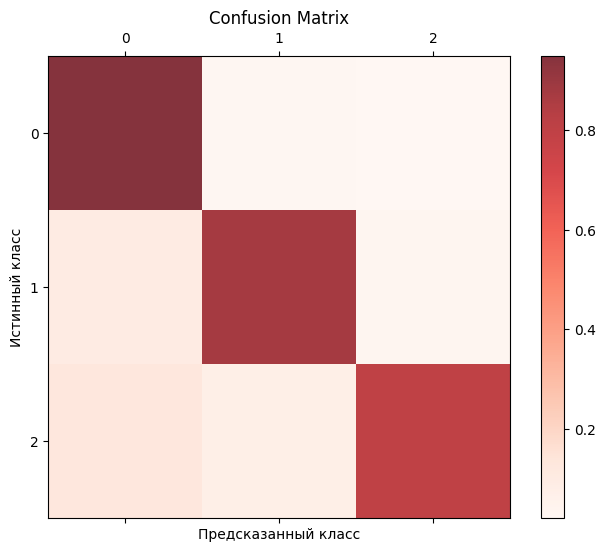

In [28]:
cm = confusion_matrix(y_test, stack.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.8)
plt.colorbar(cax)
plt.title('Confusion Matrix')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.savefig('artifacts/figures/confusion.png')

### Сохранение артефактов

In [106]:
best_model = stack

In [107]:
print(metrics_results)
print(search_summaries)

{'LogisticRegression': {'accuracy': 0.722, 'f1': 0.659966031037906, 'roc_auc': 0.8427919367389375}, 'DummyClassier': {'accuracy': 0.415, 'f1': 0.3467754141975747, 'roc_auc': 0.4986592360739018}, 'DecisionTreeClassifier': {'accuracy': 0.7786666666666666, 'f1': 0.7290730341838492, 'roc_auc': 0.8418148152169138}, 'RandomForestClassifier': {'accuracy': 0.884, 'f1': 0.8584655173602185, 'roc_auc': 0.9496376877918012}, 'AdaBoostClassifier': {'accuracy': 0.7023333333333334, 'f1': 0.6274674336438543, 'roc_auc': 0.8332641704298753}, 'StackingClassifier': {'accuracy': 0.9033333333333333, 'f1': 0.8821019435570325, 'roc_auc': 0.9569778771887719}}
{'LogisticRegression': {'best_params': {'logreg__C': 0.1}, 'best_cv_score': 0.7202500000000001}, 'DecisionTreeClassifier': {'best_params': {'max_depth': 15, 'min_samples_leaf': 5}, 'best_cv_score': 0.7370594838388832}, 'RandomForestClassifier': {'best_params': {'learning_rate': 0.8, 'n_estimators': 200}, 'best_cv_score': 0.6368238675500177}}


In [114]:
# Сохранение метрик
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(metrics_results, f, indent=2)

# Сохранение результатов поиска гиперпараметров
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=2)

# Сохранение лучшей модели
joblib.dump(best_model, 'artifacts/best_model.joblib')

# Сохранение метаданных лучшей модели
best_model_meta = {
    'model_name': 'StackingClassifier',
    'model_type': str(type(best_model)),
    'best_params': search_summaries.get('StackingClassifier', {}).get('best_params', {}),
    'cv_score': search_summaries.get('StackingClassifier', {}).get('best_cv_score', None),
    'test_metrics': metrics_results.get('StackingClassifier', {})
}

with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=2)


#### Анализ устойчивости модели для отчёта `report.md`

In [11]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=10)
dt.fit(X_train, y_train)
print_metrics(y_test, dt.predict(X_test), dt.predict_proba(X_test), title='Decision Tree Metrics 10')

Decision Tree Metrics 10
accuracy = 0.7193
f1       = 0.6240
roc_auc  = 0.8284


{'accuracy': 0.7193333333333334,
 'f1': 0.6240388987531676,
 'roc_auc': 0.8284258979010376}

In [12]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=15)
dt.fit(X_train, y_train)
print_metrics(y_test, dt.predict(X_test), dt.predict_proba(X_test), title='Decision Tree Metrics 15')

Decision Tree Metrics 15
accuracy = 0.7193
f1       = 0.6240
roc_auc  = 0.8284


{'accuracy': 0.7193333333333334,
 'f1': 0.6240388987531676,
 'roc_auc': 0.8284258979010376}

In [13]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=42)
dt.fit(X_train, y_train)
print_metrics(y_test, dt.predict(X_test), dt.predict_proba(X_test), title='Decision Tree Metrics 10')

Decision Tree Metrics 10
accuracy = 0.7193
f1       = 0.6240
roc_auc  = 0.8284


{'accuracy': 0.7193333333333334,
 'f1': 0.6240388987531676,
 'roc_auc': 0.8284258979010376}

In [14]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=87)
dt.fit(X_train, y_train)
print_metrics(y_test, dt.predict(X_test), dt.predict_proba(X_test), title='Decision Tree Metrics 10')

Decision Tree Metrics 10
accuracy = 0.7193
f1       = 0.6240
roc_auc  = 0.8284


{'accuracy': 0.7193333333333334,
 'f1': 0.6240388987531676,
 'roc_auc': 0.8284258979010376}

In [15]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=71)
dt.fit(X_train, y_train)
print_metrics(y_test, dt.predict(X_test), dt.predict_proba(X_test), title='Decision Tree Metrics 10')

Decision Tree Metrics 10
accuracy = 0.7193
f1       = 0.6240
roc_auc  = 0.8284


{'accuracy': 0.7193333333333334,
 'f1': 0.6240388987531676,
 'roc_auc': 0.8284258979010376}